# Training the Model

This notebook focuses on training the machine learning model using the preprocessed data from the previous notebook. We'll be using a neural network architecture to predict the target variable.

## Setup and Data Loading

First, we'll import the necessary libraries and load our preprocessed data.

In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import custom modules
from src.models.bert_model import TrollDetector
from src.models.trainer import TrollDetectorTrainer
from src.data_tools.dataset import TrollDataset, collate_batch

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Model Architecture

We define a neural network model using PyTorch. The architecture consists of multiple linear layers with ReLU activation functions and dropout for regularization.

In [2]:
# Define paths
DATA_DIR = Path('data')
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
CHECKPOINT_DIR = Path('./checkpoints')

# Create checkpoint directory
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Updated training configuration
config = {
    # Model configuration
    'model_name': 'distilbert-base-multilingual-cased',
    'adapter_path': None, #Dont use adapter for first training
    # 'model_name': 'ufal/robeczech-base',

    # Data parameters
    'max_length': 96,
    'batch_size': 16,

    # Training hyperparameters
    'learning_rate': 1e-5,
    'weight_decay': 0.01,
    'num_epochs': 6,
    'dropout_rate': 0.2,
    'warmup_steps': 50,
    'max_grad_norm': 1.0,
    'comments_per_user': 10,
    
    # Training control
    'early_stopping_patience': 3,
    'random_state': 17,
}

# Try to load preprocessing config
try:
    with open(PROCESSED_DATA_DIR / 'preprocessing_config.json', 'r') as f:
        preproc_config = json.load(f)
        config['random_state'] = preproc_config.get('random_state', 42)
except FileNotFoundError:
    print("Warning: preprocessing_config.json not found, using default random_state")

print("Configuration loaded:")
for key, value in config.items():
    print(f"{key}: {value}")

Configuration loaded:
model_name: distilbert-base-multilingual-cased
adapter_path: None
max_length: 96
batch_size: 16
learning_rate: 1e-05
weight_decay: 0.01
num_epochs: 6
dropout_rate: 0.2
warmup_steps: 50
max_grad_norm: 1.0
comments_per_user: 10
early_stopping_patience: 3
random_state: 42


In [3]:
# # Load preprocessed data splits
# train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train.parquet')
# val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val.parquet')
# test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test.parquet')

# # Load preprocessed small data splits
train_df = pd.read_parquet(PROCESSED_DATA_DIR / 'train_ru_only.parquet')
val_df = pd.read_parquet(PROCESSED_DATA_DIR / 'val_ru_only.parquet')
test_df = pd.read_parquet(PROCESSED_DATA_DIR / 'test_ru_only.parquet')

print("Dataset sizes:")
print(f"Train: {len(train_df)} samples, {train_df['author'].nunique()} authors")
print(f"Val:   {len(val_df)} samples, {val_df['author'].nunique()} authors")
print(f"Test:  {len(test_df)} samples, {test_df['author'].nunique()} authors")

Dataset sizes:
Train: 80735 samples, 2971 authors
Val:   17336 samples, 637 authors
Test:  16684 samples, 637 authors


In [4]:
# Create Datasets with regression settings
train_dataset = TrollDataset(
    train_df,
    tokenizer_name=config['model_name'],
    max_length=config['max_length'],
    comments_per_user=config['comments_per_user'],
    label_column='troll',  # or your trolliness score column
    normalize_labels=True  # This will automatically normalize scores to [0,1]
)

val_dataset = TrollDataset(
    val_df,
    tokenizer_name=config['model_name'],
    max_length=config['max_length'],
    comments_per_user=config['comments_per_user'],
    label_column='troll',
    normalize_labels=True
)

test_dataset = TrollDataset(
    test_df,
    tokenizer_name=config['model_name'],
    max_length=config['max_length'],
    comments_per_user=config['comments_per_user'],
    label_column='troll',
    normalize_labels=True
)

# Create dataloaders (unchanged)
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_batch
)

INFO:src.data_tools.dataset:Labels are already normalized between 0 and 1
Creating samples: 100%|███████████████████████████████████████████████████████████| 2971/2971 [00:00<00:00, 4463.69it/s]
INFO:src.data_tools.dataset:Created 6779 samples from 2971 authors
INFO:src.data_tools.dataset:Labels are already normalized between 0 and 1
Creating samples: 100%|█████████████████████████████████████████████████████████████| 637/637 [00:00<00:00, 2196.86it/s]
INFO:src.data_tools.dataset:Created 1457 samples from 637 authors
INFO:src.data_tools.dataset:Labels are already normalized between 0 and 1
Creating samples: 100%|█████████████████████████████████████████████████████████████| 637/637 [00:00<00:00, 6450.91it/s]
INFO:src.data_tools.dataset:Created 1395 samples from 637 authors


In [6]:
# Initialize Model and Trainer
model = TrollDetector(
    model_name=config['model_name'],
    adapter_path=config['adapter_path'],
    dropout_rate=config['dropout_rate'],
    use_enhanced_attention=True
)

# Initialize trainer
trainer = TrollDetectorTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    learning_rate=config['learning_rate'],
    weight_decay=config['weight_decay'],
    max_grad_norm=config['max_grad_norm'],
    num_epochs=config['num_epochs'],
    warmup_steps=config['warmup_steps'],
    checkpoint_dir=CHECKPOINT_DIR,
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.


## Training Process
Here we implement the training loop that will:
1. Iterate through batches of training data
2. Perform forward and backward passes
3. Update model parameters
4. Track and log training metrics

In [7]:
# Train the model
final_metrics = trainer.train()

print("\nTraining completed!")

INFO:src.models.trainer:Starting training...
INFO:src.models.trainer:
Epoch 1/6
Evaluating: 100%|██████████████████████████████████████████████████████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.0999]
INFO:src.models.trainer:Train metrics: {'mse': 0.17398324828259182, 'rmse': 0.4171129922246391, 'mae': 0.37424789472495684, 'r2': 0.28804808886918953, 'binary_accuracy': 0.727027027027027, 'loss': 0.5441012055665817}
INFO:src.models.trainer:Val metrics: {'mse': 0.1437580659493375, 'rmse': 0.37915440911235293, 'mae': 0.2884813504844154, 'r2': 0.4152473010242729, 'binary_accuracy': 0.7940251572327044, 'loss': 0.4179149317838576}
INFO:src.models.trainer:Saved best model with R² score: 0.4152
INFO:src.models.trainer:
Epoch 2/6
Evaluating: 100%|██████████████████████████████████████████████████████████| 92/92 [01:18<00:00,  1.18it/s, loss=0.0360]
INFO:src.models.trainer:Train metrics: {'mse': 0.09914638427084285, 'rmse': 0.3148751884014408, 'mae': 0.2281960087302896, 'r2': 0.5942858955668834, 


Best epoch: 2
Best validation metrics:
loss: 0.3300
mse: 0.0946
rmse: 0.3076
mae: 0.1937
r2: 0.6151
binary_accuracy: 0.8679

Training completed!


## Model Evaluation

We evaluate the model's performance on both training and validation sets, calculating relevant metrics to assess how well our model has learned the patterns in the data.

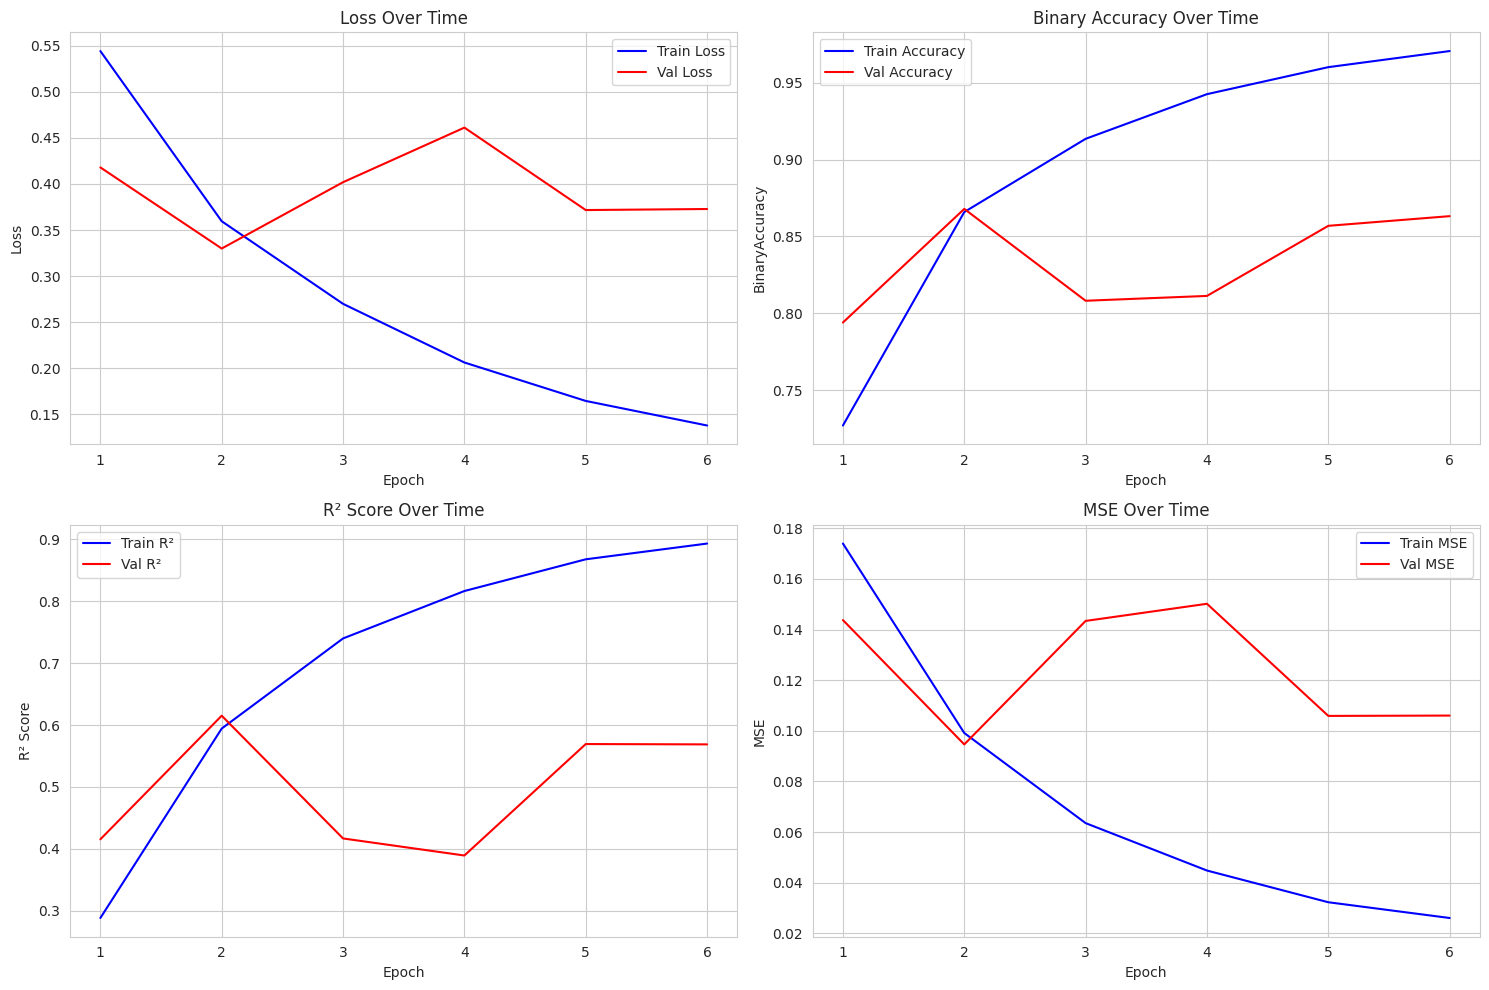

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(trainer):
    """
    Plot training history from the trainer object.
    
    Args:
        trainer: TrollDetectorTrainer instance
        save_path: Optional path to save the plot
    """
    history = trainer.history
    
    # Set style
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Create x-axis values starting at 1
    epochs = list(range(1, len(history['train']['loss']) + 1))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train']['loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val']['loss'], label='Val Loss', color='red')
    plt.title('Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train']['binary_accuracy'], label='Train Accuracy', color='blue')
    plt.plot(epochs, history['val']['binary_accuracy'], label='Val Accuracy', color='red')
    plt.title('Binary Accuracy Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('BinaryAccuracy')
    plt.legend()
    
    # Plot R² score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train']['r2'], label='Train R²', color='blue')
    plt.plot(epochs, history['val']['r2'], label='Val R²', color='red')
    plt.title('R² Score Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    
    # Plot MSE
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train']['mse'], label='Train MSE', color='blue')
    plt.plot(epochs, history['val']['mse'], label='Val MSE', color='red')
    plt.title('MSE Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.tight_layout()
    
    plt.show()

# After training is complete, you can call:
plot_training_history(trainer)

In [9]:
# Save the final model state with all necessary information
checkpoint = {
    'epoch': trainer.best_epoch, 
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'scheduler_state_dict': trainer.scheduler.state_dict(),
    'metrics': {
        'test': final_metrics
    },
    'best_val_r2': trainer.best_val_r2, 
    'best_epoch': trainer.best_epoch
}

# Save the checkpoint
final_model_path = CHECKPOINT_DIR / 'best_model_ru_only_enhanced_attention.pt'
torch.save(checkpoint, final_model_path)
print(f"\nSaved checkpoint to: {final_model_path}")

# Also save the configuration and metrics separately for easy reference
config = {
    'model_name': config['model_name'],
    'best_epoch': trainer.best_epoch,
    'best_metrics': {
        'validation_r2': trainer.best_val_r2,
        'test_metrics': final_metrics
    }
}

with open(CHECKPOINT_DIR / 'best_model_final_info.json', 'w') as f:
    json.dump(config, f, indent=4)
print(f"Saved model info to: {CHECKPOINT_DIR / 'best_model_final_info_enhanced_attention.json'}")


Saved checkpoint to: checkpoints/best_model_ru_only_enhanced_attention.pt
Saved model info to: checkpoints/best_model_final_info_enhanced_attention.json
